In [1]:
import os
import pandas as pd
import numpy as np
import bambi as bmb
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Data is from https://www.kaggle.com/datasets/mariaren/covid19-healthy-diet-dataset?select=Food_Supply_kcal_Data.csv
Descriptions of the columns can be found here: https://www.kaggle.com/datasets/mariaren/covid19-healthy-diet-dataset?select=Supply_Food_Data_Descriptions.csv

In [2]:
path="../data/Bay_LR_Covid"
file="Food_Supply_kcal_Data.csv"

In [3]:
df_food_kcal = pd.read_csv(os.path.join(path,file), header=0)

In [4]:
df_food_kcal.head()

,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetable Oils,Vegetables,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0000,4.7774,0.8504,0.0,37.1186,0.1501,0.0000,1.4757,1.2006,...,2.3012,0.7504,4.5,29.8,0.142134,0.006186,0.123374,0.012574,38928000.0,%
1,Albania,0.9120,16.0930,1.0591,0.0,16.2107,0.8091,0.1471,3.8982,3.8688,...,2.8244,2.7508,22.3,6.2,2.967301,0.050951,1.792636,1.123714,2838000.0,%
2,Algeria,0.0896,6.0326,0.1941,0.0,25.0112,0.4181,0.1195,3.1805,1.2543,...,5.7638,2.0457,26.6,3.9,0.244897,0.006558,0.167572,0.070767,44357000.0,%
3,Angola,1.9388,4.6927,0.2644,0.0,18.3521,0.0441,0.8372,2.3133,2.9302,...,4.2741,0.3525,6.8,25,0.061687,0.001461,0.056808,0.003419,32522000.0,%
4,Antigua and Barbuda,2.3041,15.3672,1.5429,0.0,13.7215,0.2057,1.7280,3.6824,7.0356,...,4.6904,1.2960,19.1,NaN,0.293878,0.007143,0.190816,0.095918,98000.0,%


Only include the columns that contain diet information as the predictors.
Response variable = "Confirmed"
"Confirmed" is the percentage of confirmed COVID-19 cases. Exclude countries that don't have this value.

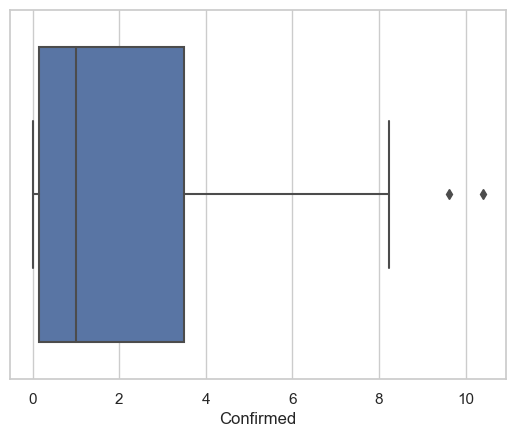

In [5]:
df=pd.concat([df_food_kcal.iloc[:, 0:24], df_food_kcal[["Confirmed"]]], axis=1).dropna()
df = df.set_index("Country")
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=df["Confirmed"])

When the confirmed rate is greater than 1%, set the value to be 1 and the rest of the records, set the value to be 0. Class 1 means that this country is the
high-risk country for covid-19. Class 0 means the country is the low-risk country.

In [6]:
df['Updated_Confirmed'] = df['Confirmed'].apply(lambda x: 0 if x <= 1 else 1)
df=df.drop(['Confirmed'], axis=1)

After creating the new label, here is a relative balanced dataset with 49.39% records with value 0 and 50.61% records with value 1. The total number of countries is 164.

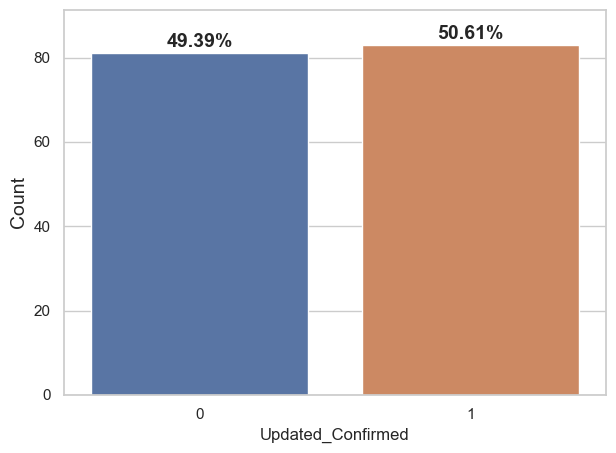

In [7]:
total = len(df)
plt.figure(figsize=(7,5))
g = sns.countplot(x='Updated_Confirmed', data=df)
g.set_ylabel('Count', fontsize=14)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 1.5,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14, fontweight='bold')
plt.margins(y=0.1)
plt.show()

Check multicollinearity

In [8]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

X = df.iloc[:,:-1]
calc_vif(X)

,variables,VIF
0,Alcoholic Beverages,1.067939e+04
1,Animal Products,6.602112e+05
2,Animal fats,2.016767e+04
3,"Aquatic Products, Other",6.963423e+00
4,Cereals - Excluding Beer,1.652935e+06
5,Eggs,1.695166e+03
6,"Fish, Seafood",4.073601e+03
7,Fruits - Excluding Wine,2.246015e+04
8,Meat,1.190340e+05
9,Milk - Excluding Butter,7.786536e+04


Remove variables that have high VIF

In [9]:
df=df.drop(['Vegetal Products','Animal Products','Aquatic Products, Other','Sugar Crops',
            'Miscellaneous','Meat','Cereals - Excluding Beer','Sugar & Sweeteners',
            'Milk - Excluding Butter','Eggs'], axis=1)

The rest of the variables have correlation less than 0.5

C:\Users\xli32\AppData\Local\Temp\ipykernel_10044\2545136278.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


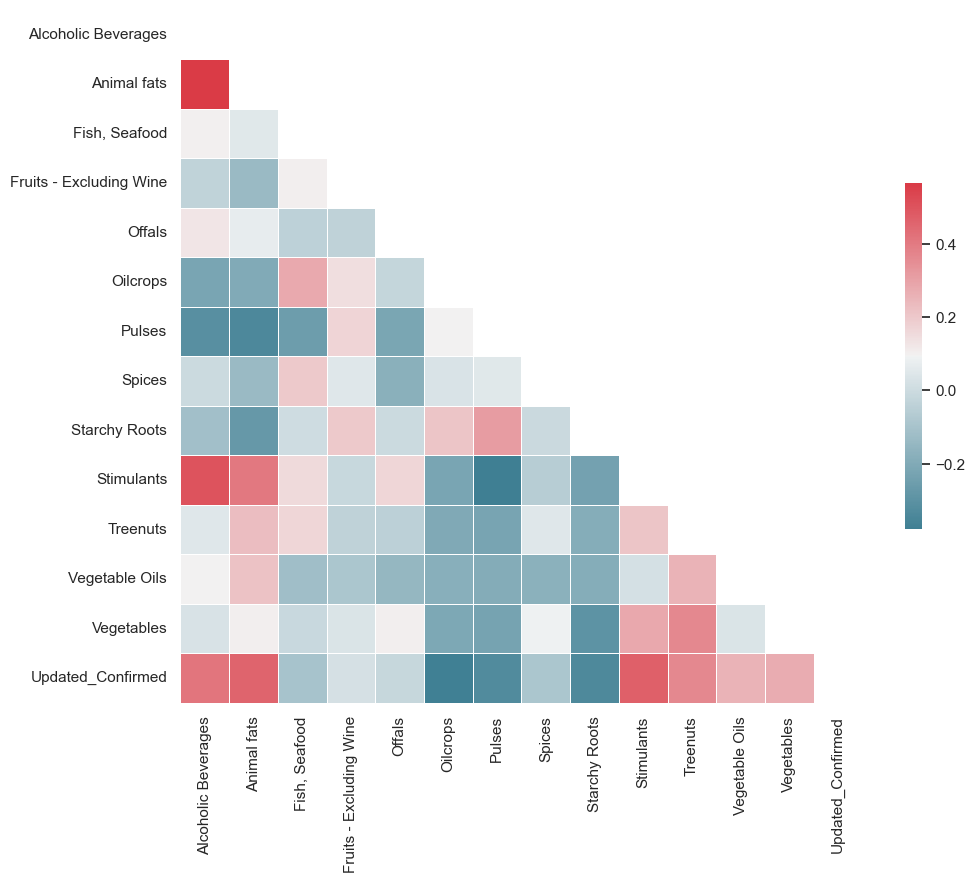

In [10]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    ax=ax,
);

In [11]:
df.columns = df.columns.str.replace(' ', '').str.replace(',', '_').str.replace('&', '_').str.replace('-', '_')

In [12]:
df.columns

Index(['AlcoholicBeverages', 'Animalfats', 'Fish_Seafood',
       'Fruits_ExcludingWine', 'Offals', 'Oilcrops', 'Pulses', 'Spices',
       'StarchyRoots', 'Stimulants', 'Treenuts', 'VegetableOils', 'Vegetables',
       'Updated_Confirmed'],
      dtype='object')

In [13]:
df.dtypes

AlcoholicBeverages      float64
Animalfats              float64
Fish_Seafood            float64
Fruits_ExcludingWine    float64
Offals                  float64
Oilcrops                float64
Pulses                  float64
Spices                  float64
StarchyRoots            float64
Stimulants              float64
Treenuts                float64
VegetableOils           float64
Vegetables              float64
Updated_Confirmed         int64
dtype: object

In [14]:
df.to_csv('../data/Bay_LR_Covid/covid_updated.csv', index=False)

In [15]:
model1 = bmb.Model("Updated_Confirmed ~ AlcoholicBeverages +  Animalfats + \
         Fish_Seafood +  Fruits_ExcludingWine +  Offals + Oilcrops + Pulses + Spices +\
       StarchyRoots + Stimulants + \
        Treenuts +  VegetableOils +  Vegetables", df, family="bernoulli")
fitted1 = model1.fit(draws=500, idata_kwargs={"log_likelihood": True})

Modeling the probability that Updated_Confirmed==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, AlcoholicBeverages, Animalfats, Fish_Seafood, Fruits_ExcludingWine, Offals, Oilcrops, Pulses, Spices, StarchyRoots, Stimulants, Treenuts, VegetableOils, Vegetables]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 284 seconds.


Based on the mean value of each coefficient, the top three negative predictors are Offals (-7.308), Oilcrops (-1.900) and Fish Seafood (-1.703). It means country where people consume more of these 3 types of food is associate with the decrease in the probability of being in the class of high-risk country for covid-19. On the contrary, it suggests people should avoid Stimulants (4.803), Treenuts (3.138) and AlcoholicBeverages (1.426) which will cause the increase of the probability of gettubg Covid.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.289,1.397,-3.903,1.325,0.033,0.023,1816.0,1371.0,1.0
AlcoholicBeverages,1.412,0.441,0.640,2.269,0.012,0.009,1421.0,1643.0,1.0
Animalfats,0.156,0.345,-0.487,0.785,0.008,0.006,2048.0,1589.0,1.0
Fish_Seafood,-1.698,0.627,-2.914,-0.555,0.018,0.013,1269.0,1431.0,1.0
Fruits_ExcludingWine,0.460,0.212,0.084,0.878,0.004,0.003,2848.0,1228.0,1.0
Offals,-7.277,2.992,-12.909,-1.632,0.070,0.051,1884.0,1685.0,1.0
Oilcrops,-1.908,0.607,-3.046,-0.791,0.014,0.010,1924.0,1683.0,1.0
Pulses,-0.136,0.299,-0.700,0.418,0.006,0.005,2149.0,1740.0,1.0
Spices,0.023,1.216,-2.245,2.227,0.023,0.027,2597.0,1514.0,1.0
StarchyRoots,-0.245,0.125,-0.480,-0.020,0.003,0.002,2055.0,1564.0,1.0


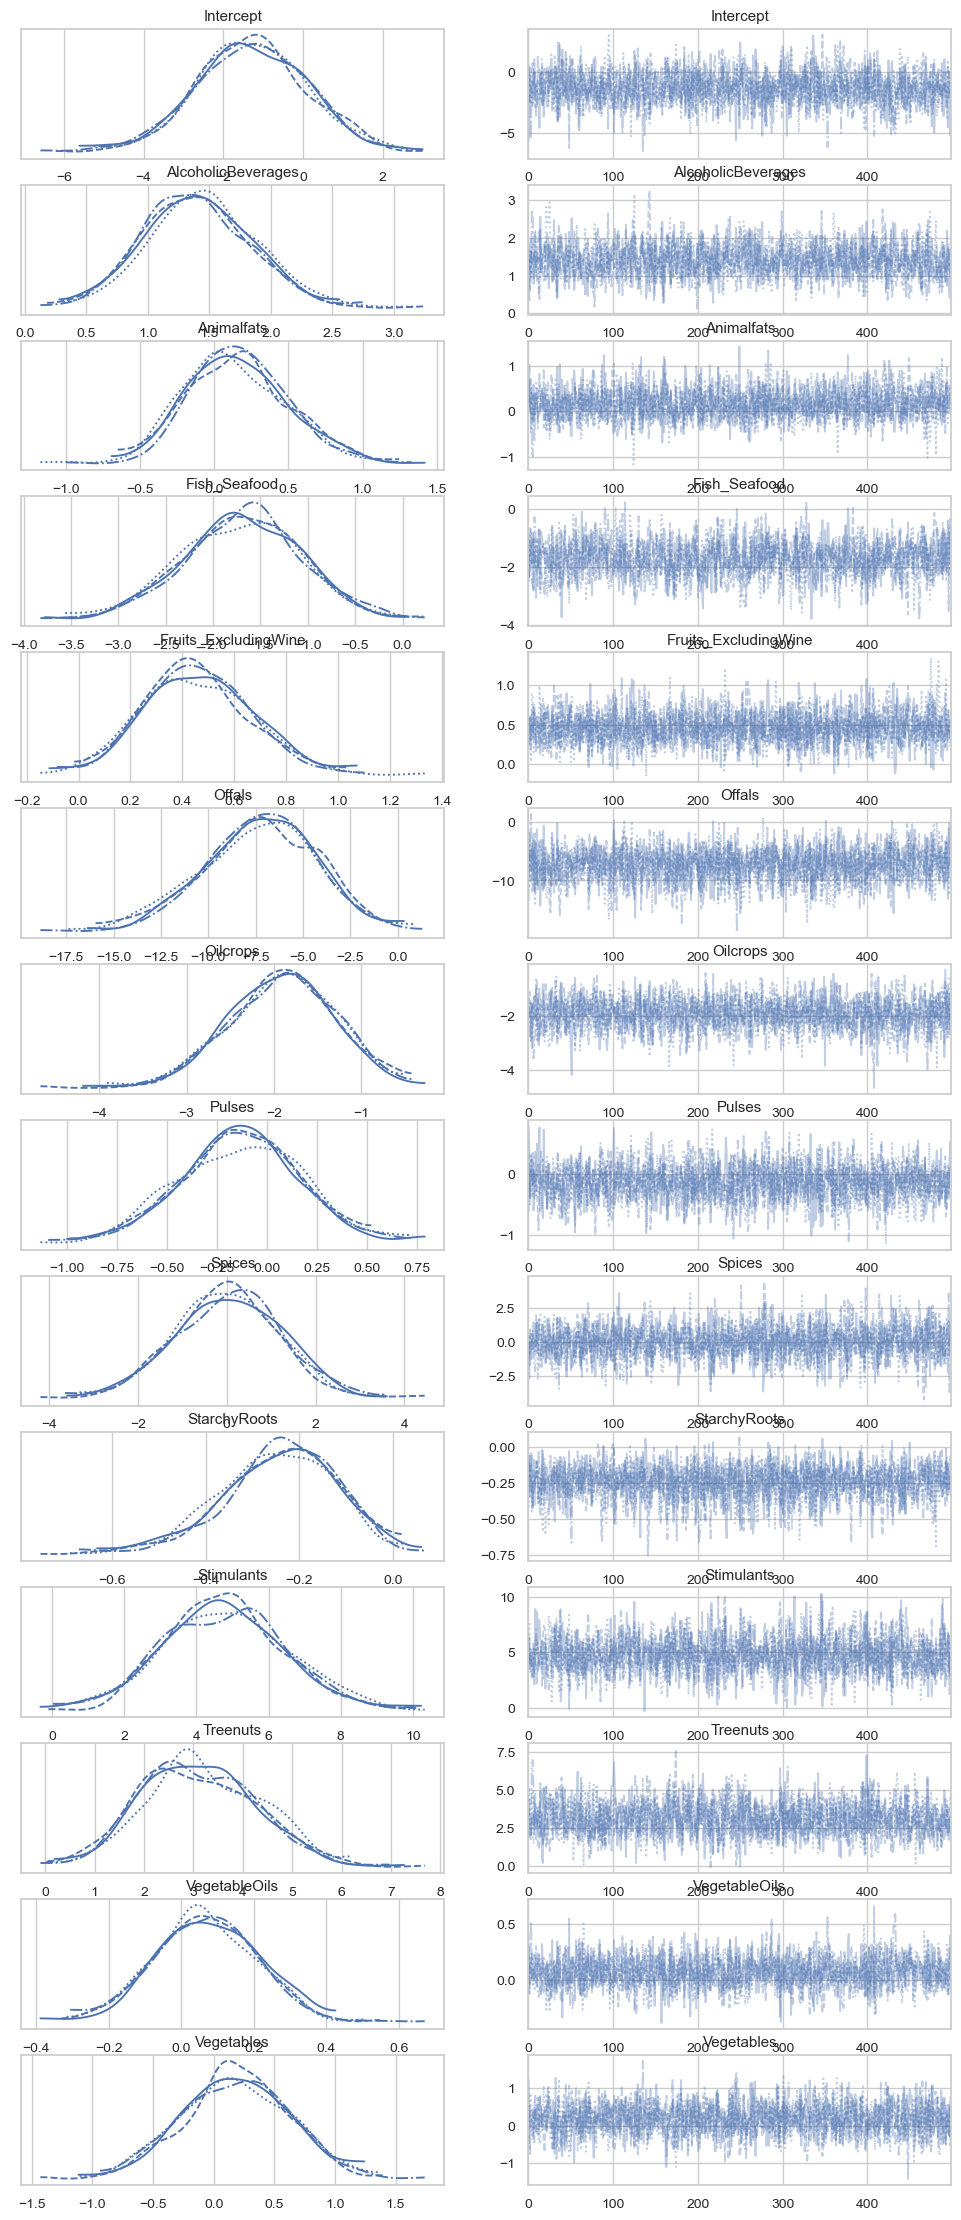

In [16]:
az.plot_trace(fitted1)
az.summary(fitted1)

In [17]:
model1.predict(fitted1, kind = "mean")

In [18]:
predict=az.extract(fitted1, group="posterior")["Updated_Confirmed_mean"]

In [19]:
train_pred = np.where(predict.mean(axis=1).values>0.5, 1, 0)
y = df['Updated_Confirmed'].values
###correctly classified
round(float((np.dot(y, train_pred) + np.dot(1 - y, 1 - train_pred)) / float(y.size) * 100),2)

85.98